In [8]:
from pathlib import Path

import networkx as nx
import torch
import yaml
from tqdm import trange, tqdm

from dql import DQNLightning
from graph import milp_solve_mds, prepare_graph, is_ds

In [2]:
# agent_path = './experiments/2024-11-06-1120/agent_220.pt'
# net_path = './experiments/2024-11-06-1120/version_0/checkpoints/epoch=99-step=99.ckpt'
# if agent_path:
#     agent = torch.load(agent_path)


FileNotFoundError: [Errno 2] No such file or directory: './experiments/2024-11-06-1120/agent_220.pt'

In [39]:
base_path = '../experiments/2025-04-16-1736/version_0'
model_path = base_path + '/checkpoints/epoch=2639-step=2640.ckpt'
hparams_path = base_path + '/hparams.yaml'

In [40]:
dqn_model: DQNLightning = DQNLightning.load_from_checkpoint(model_path, map_location=torch.device("cpu"), hparams_file=hparams_path)

Sampling 10000 instances from G(range(10, 11), 0.15)...


100%|██████████| 10000/10000 [00:30<00:00, 332.35graph/s]


In [41]:
valid_ds = []
size_eq_mlip = []

conf = yaml.safe_load(Path(hparams_path).read_text())
n, p = conf['n'], conf['p']
tt_g = 300
graphs = []

print(f'sampling {tt_g} x G{n, p}')
for i in trange(tt_g):
    g = prepare_graph(i, range(n, conf['delta_n']+1), p, milp_solve_mds, g_nx=True, attrs=conf['graph_attr'])
    graphs.append(g)

sampling 300 x G(10, 0.15)


  0%|          | 0/300 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600


  0%|          | 1/300 [00:00<00:42,  7.09it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

  4%|▍         | 13/300 [00:00<00:04, 62.42it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 10%|█         | 30/300 [00:00<00:02, 101.38it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 14%|█▎        | 41/300 [00:00<00:02, 95.60it/s] 

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 19%|█▊        | 56/300 [00:00<00:02, 112.56it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 24%|██▎       | 71/300 [00:00<00:01, 123.99it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 30%|███       | 91/300 [00:00<00:01, 146.17it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 37%|███▋      | 110/300 [00:00<00:01, 157.95it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 42%|████▏     | 127/300 [00:01<00:01, 141.50it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 47%|████▋     | 142/300 [00:01<00:01, 131.44it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 52%|█████▏    | 156/300 [00:01<00:01, 125.80it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 56%|█████▋    | 169/300 [00:01<00:01, 121.38it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 61%|██████    | 182/300 [00:01<00:01, 114.58it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 65%|██████▍   | 194/300 [00:01<00:00, 111.47it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 69%|██████▊   | 206/300 [00:01<00:00, 110.67it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 73%|███████▎  | 218/300 [00:01<00:00, 98.19it/s] 

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 76%|███████▋  | 229/300 [00:02<00:00, 91.64it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 80%|███████▉  | 239/300 [00:02<00:00, 89.62it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 84%|████████▎ | 251/300 [00:02<00:00, 94.94it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 87%|████████▋ | 261/300 [00:02<00:00, 94.08it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 90%|█████████ | 271/300 [00:02<00:00, 93.97it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 94%|█████████▍| 282/300 [00:02<00:00, 96.73it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non

 97%|█████████▋| 292/300 [00:02<00:00, 96.64it/s]

Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600
Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 3600


100%|██████████| 300/300 [00:02<00:00, 107.01it/s]


In [42]:
print(f'solving mds')
for g in tqdm(graphs):

    # Perform an episode of actions
    s = []
    dqn_model.agent.reset(g)
    for step in range(n):
        action = dqn_model.agent.get_action(dqn_model.net, 0, 'cpu')
        s.append(action)
        g.x = g.x.clone()
        g.x[action][0] = 1
        if is_ds(g.nx, s):
            break
    g.s = s

    valid_ds.append(all(v in s or len(g.nx[v].keys() & s) > 0 for v in g.nx))
    size_eq_mlip.append(len(s) <= len([i for i in g.y if i]))

solving mds


100%|██████████| 300/300 [00:01<00:00, 172.89it/s]


In [52]:
f'apx-ratio {sum(len(g.s)/(g.y == 1).sum() for g in graphs)/len(graphs):.2f} -- ' \
f'avg S_gnn {sum(len(g.s) for g in graphs)/len(graphs):.2f} -- ' \
f'avg S* {sum((g.y == 1).sum() for g in graphs)/len(graphs):.2f}'

'apx-ratio 1.10 -- avg S_gnn 4.12 -- avg S* 3.78'

In [44]:
print(f'{100*sum(valid_ds)/tt_g}% valid DS      {100*sum(size_eq_mlip)/tt_g}% equivalent to MILP')

100.0% valid DS      69.66666666666667% equivalent to MILP


In [48]:
print(conf)

{'batch_size': 5000, 'delta_n': 10, 'episode_length': 5000, 'eps_end': 0.05, 'eps_last_frame': 2000, 'eps_start': 1.0, 'gamma': 0.99, 'graph_attr': ['dominable_neighbors'], 'lr': 0.02, 'n': 10, 'n_step': 2, 'p': 0.15, 'replay_size': 100000, 's': 10000, 'sync_rate': 1024, 'validation_size': 300, 'warm_start_steps': 100000}


In [45]:
graphs[0].s

[0, 4, 7, 8]

[0, 4, 7, 8]


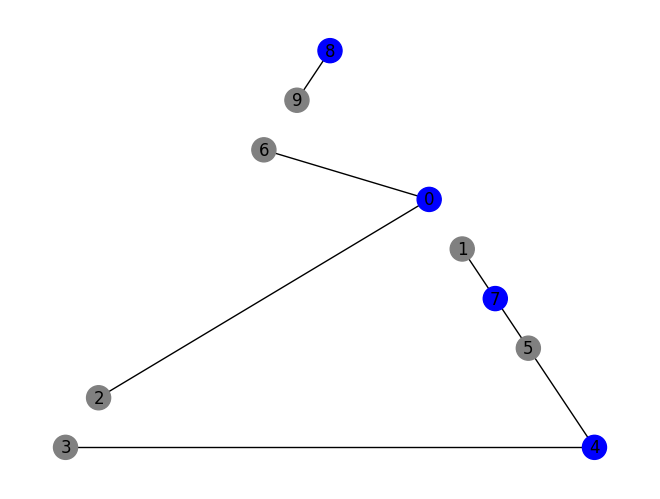

In [46]:
for g in graphs:
    if len(g.s) == len([i for i in g.y if i]):
        break
g_n = g.nx

try:
    layout = nx.planar_layout(g_n)
except:
    layout = nx.drawing.spring_layout(g_n)

node_colors = ['blue' if n in g.s else 'gray' for n in g.nx]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout)
print(g.s)

In [47]:
edge_index, node_feats = g.edge_index, torch.FloatTensor([[1]] * n)
agent.gnn(node_feats, edge_index).squeeze()

NameError: name 'agent' is not defined